# 유도변수: vorticity
- 재분석자료의 vorticity와 그 advection을 계산
- https://unidata.github.io/python-training/gallery/500hpa_vorticity_advection/ 참조

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import scipy.ndimage as ndimage

from metpy.units import units
from datetime import datetime
import xarray as xr

In [3]:
ds = xr.open_dataset('era5_pres_2020100600.nc')
lon = ds.longitude.data
lat = ds.latitude.data
lat[0], lat[-1]= 89.9, -89.9

vtime = datetime(year=2020, month=10, day=6, hour=0)
stime = vtime.strftime('%Y-%m-%d')

g = 9.806
hght_500 = ds.z.sel(time=stime, level=500).data / g
hght_500 = ndimage.gaussian_filter(hght_500, sigma=3, order=0) * units.meter

uwnd_500 = units('m/s') * ds.u.sel(time=stime, level=500).data
vwnd_500 = units('m/s') * ds.v.sel(time=stime, level=500).data

In [4]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

f = mpcalc.coriolis_parameter(np.deg2rad(lat)).reshape(len(lat),1).to(units('1/sec'))

avor = mpcalc.vorticity(uwnd_500, vwnd_500, dx, dy, dim_order='yx') + f

avor = ndimage.gaussian_filter(avor, sigma=3, order=0) * units('1/s')

vort_adv = mpcalc.advection(avor, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx') * 1e10

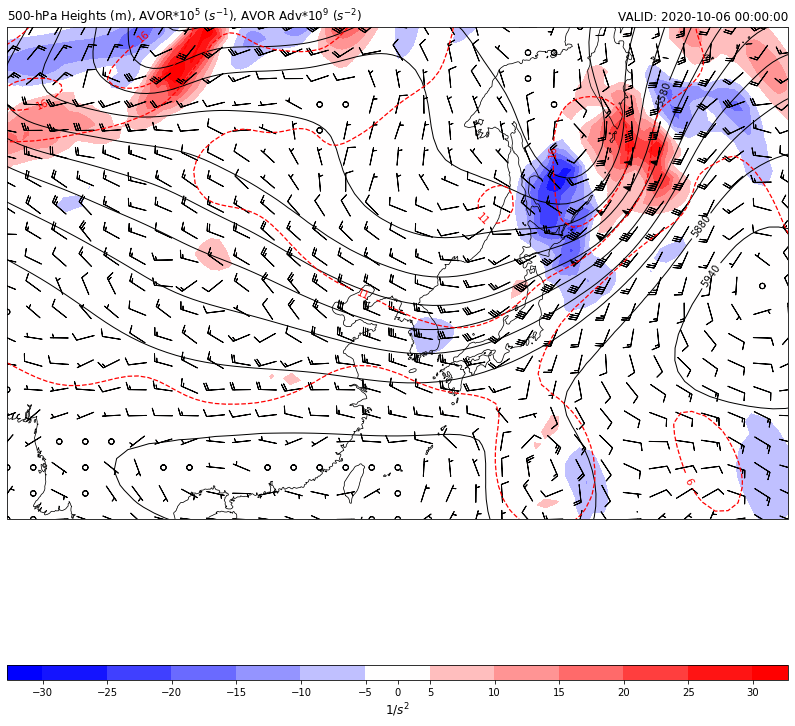

In [6]:
# Set up Coordinate System for Plot and Transforms

datacrs = ccrs.LambertConformal(central_latitude=35,
                                central_longitude=125,
                                standard_parallels=(30, 60))

fig = plt.figure(1, figsize=(14., 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=datacrs)

# Plot Titles
plt.title(r'500-hPa Heights (m), AVOR$*10^5$ ($s^{-1}$), AVOR Adv$*10^9$ ($s^{-2}$)',
          loc='left')
plt.title(f'VALID: {vtime}', loc='right')

# Plot Background
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev500 = np.arange(5100, 6061, 60)
cs = ax.contour(lon, lat, hght_500.m, clev500, colors='black', linewidths=1.0,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Absolute Vorticity Contours
clevvort500 = np.arange(-9, 50, 5)
cs2 = ax.contour(lon, lat, avor*10**5, clevvort500, colors='red',
                 linewidths=1.25, linestyles='dashed', transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Vorticity Advection
clev_avoradv = np.arange(-30, 31, 5)
cf = ax.contourf(lon, lat, vort_adv.m, clev_avoradv[clev_avoradv != 0], extend='both',
                 cmap='bwr', transform=ccrs.PlateCarree())
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect='True', ticks=clev_avoradv)
cb.set_label(r'$1/s^2$', size='large')

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
ax.barbs(lon, lat, uwnd_500.m, vwnd_500.m, length=6, regrid_shape=20,
         pivot='middle', transform=ccrs.PlateCarree())